In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
import os
import random
import fnmatch
import datetime
import pickle

In [3]:
import numpy as np
np.set_printoptions(formatter={'float_kind': lambda x: "%.4f" % x})

In [4]:
import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [6]:
print(f'tf.__version__: {tf.__version__}')
print(f'.keras.__version__: {tensorflow.keras.__version__}')

tf.__version__: 2.8.2
.keras.__version__: 2.8.0


In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [8]:
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

image_path: /content/drive/My Drive/Colab Notebooks/autocar/train/S_00488.png
steering_Angle: 488


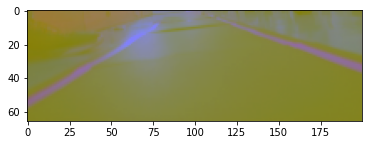

In [9]:
data_dir = '/content/drive/My Drive/Colab Notebooks/autocar/train'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = '*.png'
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print(f"image_path: {image_paths[image_index]}")
print(f"steering_Angle: {steering_angles[image_index]}")
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([28.0000, 28.0000, 28.0000, 20.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 14.0000, 28.0000,
        28.0000, 28.0000, 22.0000, 0.0000, 0.0000, 0.0000, 23.0000,
        28.0000, 28.0000]),
 array([2.0000, 29.8400, 57.6800, 85.5200, 113.3600, 141.2000, 169.0400,
        196.8800, 224.7200, 252.5600, 280.4000, 308.2400, 336.0800,
        363.9200, 391.7600, 419.6000, 447.4400, 475.2800, 503.1200,
        530.9600, 558.8000, 586.6400, 614.4800, 642.3200, 670.1600,
        698.0000]),
 <a list of 25 Patch objects>)

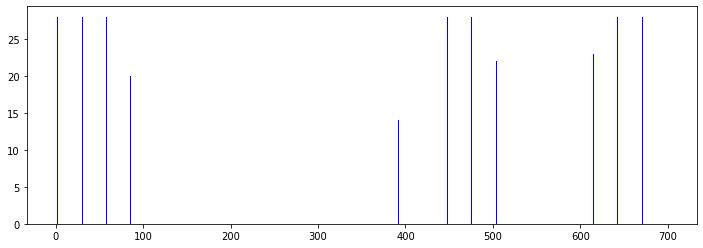

In [10]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 242
Validation data: 61


Text(0.5, 1.0, 'Validation Data')

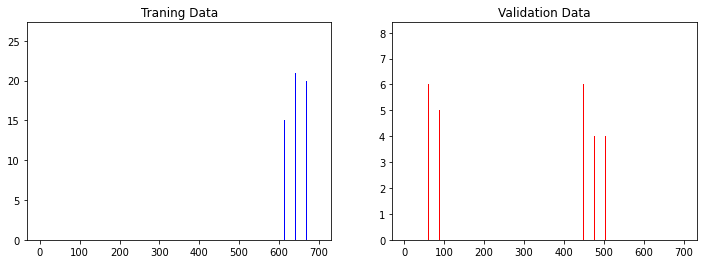

In [11]:
# 학습 데이터와 검증 데이터를 분리하기
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print(f"Training data: {len(X_train)}\nValidation data: {len(X_valid)}")

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Traning Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'processed')

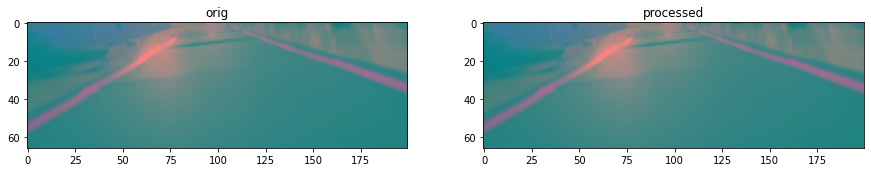

In [12]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    return image

def img_preprocess(image):
    image = image / 255
    return image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [13]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    model.add(Conv2D(24, (5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dropout (Dropout)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 100)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


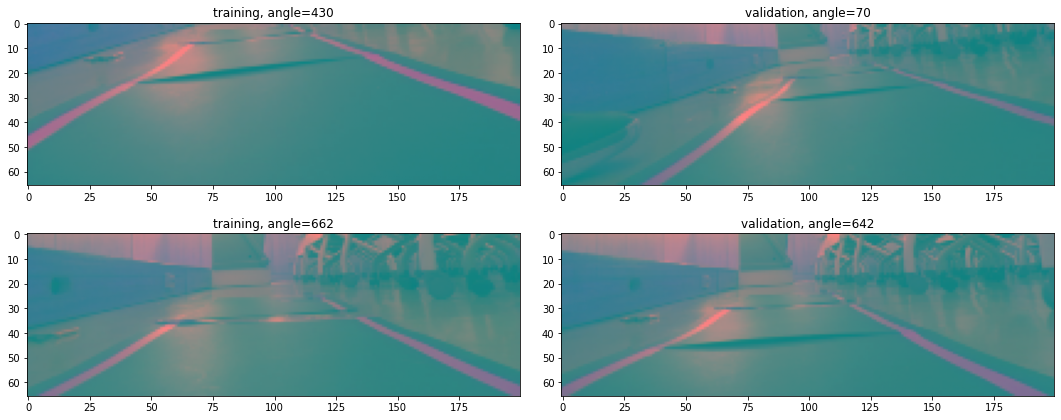

In [14]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]

            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)

        yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [15]:
!pwd
!ls

/content
drive  sample_data


In [16]:
model_output_dir = '/content/drive/My Drive/Colab Notebooks/autocar/data'

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), verbose=1, save_best_only=True)
history = model.fit_generator(image_data_generator(X_train, y_train, batch_size=100),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator(X_valid, y_valid, batch_size=100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(os.path.join(model_output_dir, 'lane_navigation_final.h5'))
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 32906.0859
Epoch 1: val_loss improved from inf to 566.09851, saving model to /content/drive/My Drive/Colab Notebooks/autocar/data/lane_navigation_check.h5
300/300 [==============================] - 140s 431ms/step - loss: 32906.0859 - val_loss: 566.0985
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 275.8889
Epoch 2: val_loss improved from 566.09851 to 69.91277, saving model to /content/drive/My Drive/Colab Notebooks/autocar/data/lane_navigation_check.h5
300/300 [==============================] - 124s 415ms/step - loss: 275.8889 - val_loss: 69.9128
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 135.5690
Epoch 3: val_loss improved from 69.91277 to 39.95745, saving model to /content/drive/My Drive/Colab Notebooks/autocar/data/lane_navigation_check.h5
300/300 [==============================] - 123s 410ms/step - loss: 135.5690 - val_loss: 39.9575
Epoch 4/10
300/300 [=========

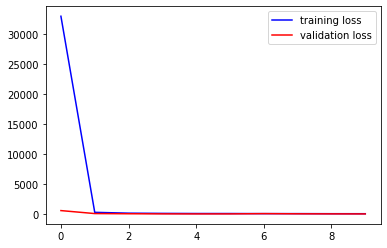

In [17]:
history.history

history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.legend(['training loss', 'validation loss'])

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'mse = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()

mse = 1.2e+01
r_squared = 99.97%



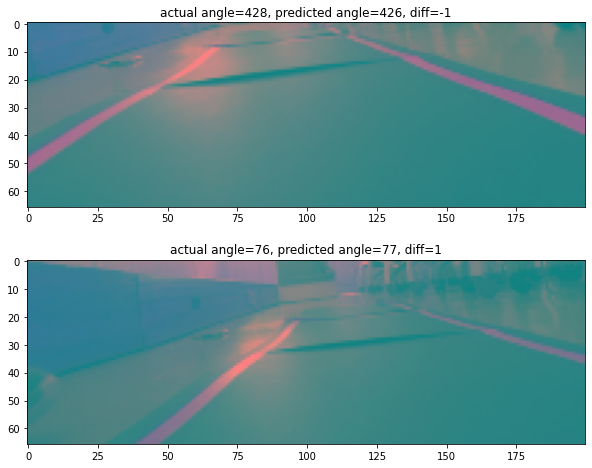

In [23]:
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))
y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff={int(y_pred[i]-y_test[i])}")